# Library

In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt

import torchvision.utils as utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from sklearn.metrics import confusion_matrix

# Set torch constants

In [2]:
# CUDA Check
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Set dtype
dtype = torch.double

# Load the data and check the data

In [3]:
mnist_train = datasets.MNIST(
    root="data/",
    train=True,
    transform=transforms.ToTensor(),
    download=True)

mnist_test = datasets.MNIST(
    root="data/",
    train=False,
    transform=transforms.ToTensor(),
    download=True)

print(mnist_train)
print(mnist_test)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: ToTensor()


Original train example # 29538
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,  

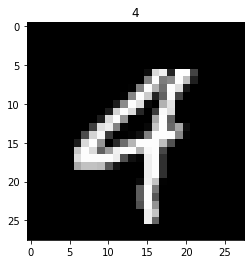

In [4]:
# Rename the data and labels
X_train = mnist_train.data
y_train = mnist_train.targets
X_test = mnist_test.data
y_test = mnist_test.targets

# Data check
idx = np.random.randint(0, X_train.shape[0])

print("Original train example # " + str(idx))
print(X_train[idx])

plt.figure()
plt.imshow(X_train[idx], cmap='gray')
plt.title(y_train[idx].item())
plt.show()

# Make custom dataloader

In [5]:
# Check a example's shape
shape = X_train.shape[1:]
print("Data shape : ", shape)

# Construct custom dataloader for train
class MNIST_Dataset(torch.utils.data.Dataset):
    # Initialize and preprocess the data
    def __init__(self, is_train):
        # MNIST data convert to cuda tensor and change the data type
        # Train case and test case should be differentiated!
        if is_train:
            X = X_train.to(dtype=dtype, device=device)
            y = y_train.to(device=device)
        else:
            X = X_test.to(dtype=dtype, device=device)
            y = y_test.to(device=device)
        
        # Normalize
        X = self._normalize(X, 0, 255)
        
        # Reshape the data
        X = self._reshape(X)
        
        # Move to the class object
        self.X = X
        self.y = y
    
    def __len__(self):
        # Return the data lenght
        
        return self.y.shape[0]
    
    def __getitem__(self, idx):
        # Return a idx'th item in dataset
        
        return self.X[idx], self.y[idx]
    
    def _normalize(self, data, min_value, max_value):
        # Nomalize the dataset with minimax normalizer
        
        # Arugments
        # data : tensor object for images
        # min_value : the smallest value in the data
        # max_value : the largest value in the data
        
        return (data - min_value) / (max_value - min_value)
    
    def _reshape(self, data):
        # Reshape the data
        
        # Arguments
        # data : dataset's tensor object with original image's dimension
        # shape : (batch size, 1, 28, 28)
        
        return data.view(-1, 1, 28, 28)

Data shape :  torch.Size([28, 28])


# Set hyperparameters

In [7]:
# Hyperparameters
learning_rate = 0.1
training_epochs = 25
display_step = 5

batch_size = 100

D_in = (1, 28, 28)

# Make batch with dataloader

batch train data example shape :  torch.Size([100, 1, 28, 28])
batch test data example :  torch.Size([100, 1, 28, 28])


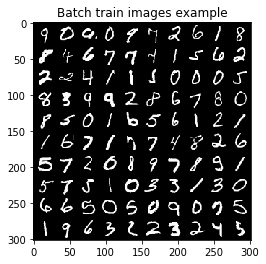

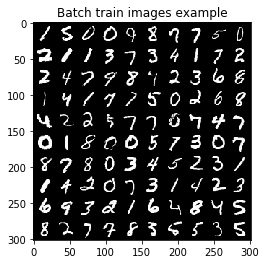

In [8]:
# Show image of batch data
def show_grid_image(img, title):
    n_img = img.shape[0]
    img = utils.make_grid(img.cpu().detach(), nrow = int(np.ceil(np.sqrt(n_img))))
    
    np_img = img.numpy()
    
    plt.figure()
    plt.imshow(np.transpose(np_img, (1, 2, 0)), cmap='gray')
    plt.title(title)
    plt.show()

# Instantiate datalodaer
train_data_loader = torch.utils.data.DataLoader(MNIST_Dataset(is_train=True), batch_size, shuffle=True)
test_data_loader = torch.utils.data.DataLoader(MNIST_Dataset(is_train=False), batch_size, shuffle=True)

# Extract batch examples
batch_train_data_example, batch_train_label_example = next(iter(train_data_loader))
batch_test_data_example, batcifar_trainch_test_label_example = next(iter(test_data_loader))
print("batch train data example shape : ", batch_train_data_example.shape)
print("batch test data example : ", batch_test_data_example.shape)

# Show the batch images
show_grid_image(batch_train_data_example, "Batch train images example")
show_grid_image(batch_test_data_example, "Batch train images example")

# Initialize parameters

In [11]:
# Initialize model parameters
def initialize_parameters(model):
    for p in model.parameters():
        if (p.dim() > 1):
            torch.nn.init.xavier_normal_(p)
        else:
            torch.nn.init.uniform_(p, 0.1, 0.2)

# Construct the model

In [14]:
# Construct a convolution neural netwok
class CNN(torch.nn.Module):
    def __init__(self):
        # Initialize model parameters
        super(CNN, self).__init__()
        # Layer1 structure - Input: (-, 28, 28, 1)
        # (-, 32, 32, 1) --Conv2d--> (-, 28, 28, 32) NEW!
        # (-, 28, 28, 32) --ReLU--> (-, 28, 28, 32)
        # (-, 28, 28, 32) --MaxPool2d--> (-, 14, 14, 32) NEW!
        
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Layer 2 structure - Input: (-, 14, 14, 32)
        # (-, 14, 14, 32) --Conv2d--> (-, 14, 14, 64)
        # (-, 14, 14, 64) --ReLU--> (-, 14, 14, 64)
        # (-, 14, 14, 64) --MaxPool2d--> (-, 7, 7, 64)
        
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Fully connected structure - Input: (-, 7, 7, 64)
        # Make input be flat
        
        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)
        
    def forward(self, x):
        # Calculate the forward process
        
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.fc(output.view(output.size(0), -1))
        
        return output

# Make the model
model = CNN().to(dtype=dtype, device=device)

# Set loss function and optimizer
criterion = torch.nn.CrossEntropyLoss(reduction="mean")
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Train the model

In [15]:
losses = []

model.train()
initialize_parameters(model)

print("Training...")

for epoch in range(training_epochs):
    avg_loss = 0
    
    for data in train_data_loader:
        images, labels = data
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        avg_loss += loss.item() / batch_size
        
        loss.backward()
        optimizer.step()
    
    losses.append(avg_loss)
    
    if (epoch + 1) % display_step == 0:
        print("epoch " + str(epoch + 1) + " : ", losses[-1])
    
print("Finsh training")

# Save the model parameters
torch.save(model.state_dict(), "cnn.pt")

Training...
epoch 5 :  0.2937536279678188
epoch 10 :  0.18215640602228314
epoch 15 :  0.12662821042722516
epoch 20 :  0.09242489106829126
epoch 25 :  0.06437668034566307
Finsh training


# Train results

In [16]:
def plot_losses(losses):
    # Set figure and show the graph
    plt.figure()
    plt.plot(losses, label="loss")
    plt.legend()
    plt.show()

def show_accuracies(model, train_data_loader, test_data_loader):
    # We don't need to calculate the gradients
    with torch.no_grad():
        # Change the mode for model to evaluate
        model.eval()
    
        # Show train accuracy
        train_corrects = 0
        train_total = 0
        
        # If your graphic card can't afford to compute model at once, you can use the batch!
        for data in train_data_loader:
            # Extract the images and labels from data
            images, labels = data
            
            outputs = model(images)
            _, predictions = torch.max(outputs, axis=1)
            train_total += labels.size(0)
            train_corrects += (labels == predictions).sum().item()
    
        print("Train accuracy : ", (train_corrects / train_total) * 100, "%")
    
        # Show test accuracy
        test_corrects = 0
        test_total = 0
    
        # If your graphic card can't afford to compute model at once, you can use the batch!
        for data in test_data_loader:
            # Extract the images and labels from data
            images, labels = data
            
            outputs = model(images)
            _, predictions = torch.max(outputs, axis=1)
            test_total += labels.size(0)
            test_corrects += (labels == predictions).sum().item()
    
        print("Test accuracy : ", (test_corrects / test_total) * 100, "%")

def show_confusion_matrix(model, test_data_loader):
    # Change the mode for model to evaluate
    model.eval()
    
    # Show confusion matrix
    total_predictions = torch.empty(0).to(dtype=torch.long, device=device)
    total_labels = torch.empty(0).to(dtype=torch.long, device=device)
    
    for data in test_data_loader:
        # Extract the images and labels from data
        images, labels = data
        
        outputs = model(images)
        _, predictions = torch.max(outputs, axis=1)
        total_predictions = torch.cat((predictions, total_predictions), axis=0)
        total_labels = torch.cat((labels, total_labels), axis=0)
        
    total_predictions_ = total_predictions.cpu().detach().numpy()
    total_labels_ = total_labels.cpu().detach().numpy()
    
    print("Confusion matrix \n", confusion_matrix(total_labels_, total_predictions_))

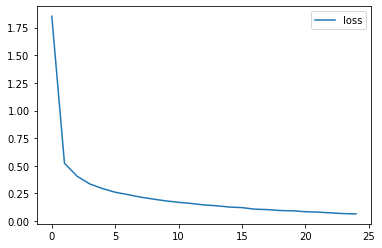

Train accuracy :  99.70833333333333 %
Test accuracy :  98.92 %
Confusion matrix 
 [[ 977    0    0    0    0    0    1    1    1    0]
 [   0 1126    3    2    1    0    0    0    3    0]
 [   2    0 1018    1    1    0    0    4    6    0]
 [   0    0    0 1005    0    3    0    0    2    0]
 [   0    0    0    0  978    0    1    2    0    1]
 [   2    0    0    6    0  878    2    1    3    0]
 [   4    2    1    0    1    1  945    0    4    0]
 [   0    0    2    3    0    0    0 1022    1    0]
 [   3    0    3    1    0    1    0    0  965    1]
 [   2    2    0    1   14    5    0    4    3  978]]


In [17]:
# Plot losses
plot_losses(losses)

# Show train accuracy and test accuracy
show_accuracies(model, train_data_loader, test_data_loader)

# Show confusion matrix
show_confusion_matrix(model, test_data_loader)

# Show the model inside

In [ ]:
pass

# Predict the images

In [ ]:
def show_image(img, label):
    # Reshape the input
    
    
    # Show the image
    
    

def predict(model, X, idx):
    # Change the mode for model to evaluate
    
    
    # Reshape the input
    
    
    # Calculate the probability
    
    
    # Pick the largest probability label
    
    
    return label_pred

In [ ]:
# Have to correct!
n = 10 # Number to predict

# Make the dataloader for prediction


# Extract first batch data from dataloader
images, labels = next(iter(predict_data_loader))

for i in range(n):
    true_label = # Fill the code
    pred_label = # Fill the code
    
    # Show the image
    
    
    print("Predicted label : ", pred_label)
    print("True label : ", true_label)

# Improve the performance with regularization

# Construct the model

In [18]:
# Construct a convolution neural netwok
class CNNR(torch.nn.Module):
    def __init__(self):
        super(CNNR, self).__init__()
        # Convolution Layer1 structure - Input: (-, 28, 28, 1)
        # (-, 32, 32, 1) --Conv2d--> (-, 28, 28, 16)
        # (-, 28, 28, 16) --BatchNorm2d--> (-, 28, 28, 16)
        # (-, 28, 28, 16) --ReLU--> (-, 28, 28, 16)
        
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU()
        )
        
        # Convolution Layer2 structure - Input: (-, 28, 28, 16)
        # (-, 28, 28, 16) --Conv2d--> (-, 28, 28, 32)
        # (-, 28, 28, 32) --BatchNorm2d--> (-, 28, 28, 32)
        # (-, 28, 28, 32) --ReLU--> (-, 28, 28, 32)
        # (-, 28, 28, 32) --MaxPool2d--> (-, 14, 14, 32)
        
        # Fill the code
        
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Convolution Layer3 structure - Input: (-, 14, 14, 32)
        # (-, 14, 14, 32) --Conv2d--> (-, 14, 14, 64)
        # (-, 14, 14, 64) --BatchNorm2d--> (-, 14, 14, 64)
        # (-, 14, 14, 64) --ReLU--> (-, 14, 14, 64)
        # (-, 14, 14, 64) --MaxPool2d--> (-, 7, 7, 64)
        
        # Fill the code
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Fully connected1 structure - Input: (-, 7, 7, 64)
        # Make input be flat
        # (-, 7, 7, 64) --Flatten--> (-, 3136)
        # (-, 3136) --Linear--> (- 256)
        # (-, 256) --BatchNorm1d--> (-, 256)
        # (-, 256) --ReLU--> (-, 256)
        
        # Fill the code
        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(7 * 7 * 64, 256),
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU()
        )
        
        # Fully connected2 structure - Input: (-, 256)
        # (-, 256) --Linear--> (-, 10)
        
        # Fill the code
        
        self.fc2 = torch.nn.Sequential(
            torch.nn.Linear(256, 10)
        )
            
    def forward(self, x):
        # Initialize model parameters
        
        # Fill the code
        
        output = self.conv1(x)
        output = self.conv2(output)
        output = self.conv3(output)
        output = self.fc1(output.view(output.size(0), -1))
        output = self.fc2(output)
        
        return output

# Make the model
model = CNNR().to(dtype=dtype, device=device)

# Set loss function and optimizer
criterion = torch.nn.CrossEntropyLoss(reduction="mean")
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Train the model

In [19]:
losses = []

model.train()
initialize_parameters(model)

print("Training...")

for epoch in range(training_epochs):
    avg_loss = 0
    
    for data in train_data_loader:
        images, labels = data
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        avg_loss += loss.item() / batch_size
        
        loss.backward()
        optimizer.step()
    
    losses.append(avg_loss)
    
    if (epoch + 1) % display_step == 0:
        print("epoch " + str(epoch + 1) + " : ", losses[-1])
    
print("Finsh training")

# Save the model parameters
torch.save(model.state_dict(), "cnn.pt")

Training...
epoch 5 :  0.15197377289269465
epoch 10 :  0.05379271078602753
epoch 15 :  0.023012883182053162
epoch 20 :  0.010498558591976098
epoch 25 :  0.006790574105905595
Finsh training


# Train results

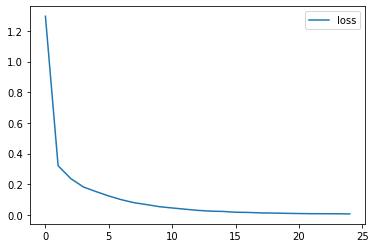

Train accuracy :  100.0 %
Test accuracy :  99.19 %
Confusion matrix 
 [[ 976    1    1    0    0    0    1    1    0    0]
 [   0 1132    1    1    1    0    0    0    0    0]
 [   1    2 1023    0    1    0    0    5    0    0]
 [   0    0    1 1005    0    3    0    0    1    0]
 [   0    0    1    0  973    0    1    0    1    6]
 [   2    1    0    7    0  879    1    0    1    1]
 [   3    1    0    1    1    3  949    0    0    0]
 [   0    2    2    0    0    0    0 1020    1    3]
 [   1    0    0    2    0    1    0    0  968    2]
 [   1    0    0    2    5    2    0    4    1  994]]


In [20]:
# Plot losses
plot_losses(losses)

# Show train accuracy and test accuracy
show_accuracies(model, train_data_loader, test_data_loader)

# Show confusion matrix
show_confusion_matrix(model, test_data_loader)